In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_path = '/dfs/project/perturb-gnn/datasets/Norman2019/Norman2019_hvg+perts_more_de.h5ad'
adata = sc.read_h5ad(data_path)
gene_list = [f for f in adata.var.gene_symbols.values]

# calculate mean expression for each condition
unique_conditions = adata.obs.condition.unique()
conditions2index = {}
for i in unique_conditions:
    conditions2index[i] = np.where(adata.obs.condition == i)[0]
    
condition2mean_expression = {}
for i, j in conditions2index.items():
    condition2mean_expression[i] = np.mean(adata.X[j], axis = 0)
    
pert_list = np.array(list(condition2mean_expression.keys()))
mean_expression = np.array(list(condition2mean_expression.values())).reshape(len(adata.obs.condition.unique()), adata.X.toarray().shape[1])

ctrl = mean_expression[np.where(pert_list == 'ctrl')[0]]
most_variable_genes = np.argsort(np.std(mean_expression, axis = 0))[-200:]
gene_list = adata.var['gene_name'].values

In [2]:
from data import PertDataloader, Network

model_name = 'GNN_Disentangle_GAT_string_20.0_64_2_l3_Norman2019_gamma2_gene_emb_pert_emb_constant_lambda_emission'
args = np.load('./saved_args/'+model_name+'.npy', allow_pickle = True).item()
args['test_perts'] = 'N/A'
if args['network_name'] == 'string':
    args['network_path'] = '/dfs/project/perturb-gnn/graphs/STRING_full_9606.csv'

if 'gene_symbols' not in adata.var.columns.values:
    adata.var['gene_symbols'] = adata.var['gene_name']
gene_list = [f for f in adata.var.gene_symbols.values]
# Set up message passing network
network = Network(fname=args['network_path'], gene_list=args['gene_list'],
                  percentile=args['top_edge_percent'])

# Pertrubation dataloader
pertdl = PertDataloader(adata, network.G, network.weights, args)

There are 101013 edges in the PPI.
Creating pyg object for each cell in the data...
Local copy of pyg dataset is detected. Loading...
Loading splits...
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Creating dataloaders....
Dataloaders created...


In [3]:
X = adata.X

In [4]:
train_perts = pertdl.set2conditions['train']

In [5]:
X_tr = X[np.isin(adata.obs.condition, [i for i in train_perts if 'ctrl' in i])]

In [6]:
gene_list = adata.var['gene_name'].values

In [7]:
def np_pearson_cor(x, y):
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    # bound the values to -1 to 1 in the event of precision issues
    return np.maximum(np.minimum(result, 1.0), -1.0)

X_tr = X_tr.toarray()

out = np_pearson_cor(X_tr, X_tr)

/tmp/ipykernel_4906/724921210.py:6: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


In [9]:
idx2gene = dict(zip(range(len(gene_list)), gene_list))

In [10]:
out[np.isnan(out)] = 0

In [11]:
out = np.abs(out)

In [12]:
out_sort_idx = np.argsort(out)[:, -11:]
out_sort_val = np.sort(out)[:, -11:]

In [13]:
df_g = []
for i in range(out_sort_idx.shape[0]):
    target = idx2gene[i]
    for j in range(out_sort_idx.shape[1]):
        
        df_g.append((idx2gene[out_sort_idx[i, j]], target, out_sort_val[i, j]))

In [19]:
df_g = [i for i in df_g if i[2] > 0.4]

In [20]:
df_co_expression = pd.DataFrame(df_g).rename(columns = {0: 'source', 1: 'target', 2: 'importance'})

In [22]:
df_co_expression.to_csv('co_expression_abs_high.csv', index = False)

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

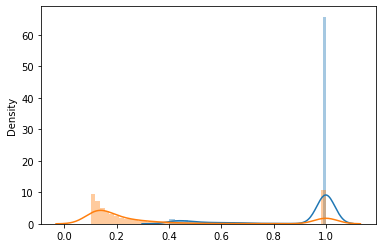

In [21]:
import seaborn as sns
sns.distplot(df_co_expression.importance.values)
sns.distplot(pd.read_csv('co_expression.csv').importance.values)